##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural style transfer

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This tutorial uses deep learning to compose one image in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as *neural style transfer* and the technique is outlined in <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.). 

Note: This tutorial demonstrates the original style-transfer algorithm. It optimizes the image content to a particular style. Modern approaches train a model to generate the stylized image directly (similar to [CycleGAN](./cyclegan.ipynb)). This approach is much faster (up to 1000x).

For a simple application of style transfer with a pretrained model from [TensorFlow Hub](https://tfhub.dev), check out the [Fast style transfer for arbitrary styles](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) tutorial that uses an [arbitrary image stylization model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2). For an example of style transfer with [TensorFlow Lite](https://www.tensorflow.org/lite), refer to [Artistic style transfer with TensorFlow Lite](https://www.tensorflow.org/lite/examples/style_transfer/overview).

Neural style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
from os import walk
import time
import cv2
from skimage.metrics import structural_similarity as ssim

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

./ImagesForTraining
./StylesForTraining
['Vasiliy_Kandinskiy_2.jpg', 'Vasiliy_Kandinskiy_25.jpg', 'Vasiliy_Kandinskiy_74.jpg', 'Vasiliy_Kandinskiy_78.jpg', 'Vasiliy_Kandinskiy_9.jpg']

input_1
conv1
conv1_bn
conv1_relu
conv_dw_1
conv_dw_1_bn
conv_dw_1_relu
conv_pw_1
conv_pw_1_bn
conv_pw_1_relu
conv_pad_2
conv_dw_2
conv_dw_2_bn
conv_dw_2_relu
conv_pw_2
conv_pw_2_bn
conv_pw_2_relu
conv_dw_3
conv_dw_3_bn
conv_dw_3_relu
conv_pw_3
conv_pw_3_bn
conv_pw_3_relu
conv_pad_4
conv_dw_4
conv_dw_4_bn
conv_dw_4_relu
conv_pw_4
conv_pw_4_bn
conv_pw_4_relu
conv_dw_5
conv_dw_5_bn
conv_dw_5_relu
conv_pw_5
conv_pw_5_bn
conv_pw_5_relu
conv_pad_6
conv_dw_6
conv_dw_6_bn
conv_dw_6_relu
conv_pw_6
conv_pw_6_bn
conv_pw_6_relu
conv_dw_7
conv_dw_7_bn
conv_dw_7_relu
conv_pw_7
conv_pw_7_bn
conv_pw_7_relu
conv_dw_8
conv_dw_8_bn
conv_dw_8_relu
conv_pw_8
conv_pw_8_bn
conv_pw_8_relu
conv_dw_9
conv_dw_9_bn
conv_dw_9_relu
conv_pw_9
conv_pw_9_bn
conv_pw_9_relu
conv_dw_10
conv_dw_10_bn
conv_dw_10_relu
conv_pw_10
conv_pw_10_b

[('poncho', 0.10525841),
 ('chain', 0.08612738),
 ('rapeseed', 0.07804999),
 ('coral_reef', 0.07297865),
 ('wool', 0.058500018)]

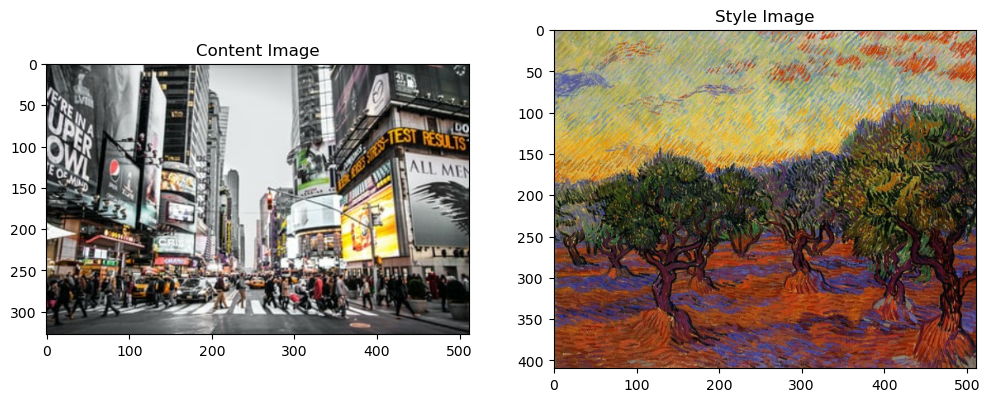

In [6]:
## Get lists that store the file names for content and style pictures 

# folder path
dir_path = './ImagesForTraining'

# list to store files name
allImagesContent = []
for (dir_path, dir_names, file_names) in walk(dir_path):
    print(dir_path)
    allImagesContent.extend(file_names)
#print(allImagesContent)


dir_path = './StylesForTraining'

# list to store files name
allImagesStyle = []
for (dir_path, dir_names, file_names) in walk(dir_path):
    print(dir_path)
    allImagesStyle.extend(file_names)
print(allImagesStyle)

# Print the layers of MobileNet
mobile_net = tf.keras.applications.MobileNet(include_top=True, weights='imagenet')

print()
for layer in mobile_net.layers:
  print(layer.name)


content_image = load_img("unsplash-images-collection/photo-1529218402470-5dec8fea0761.jpg")
style_image = load_img("Art/resized/resized/Vincent_van_Gogh_288.jpg")

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

x = tf.keras.applications.mobilenet.preprocess_input(style_image*255)
x = tf.image.resize(x, (224, 224))
mobile_net = tf.keras.applications.MobileNet(include_top=True, weights='imagenet')
prediction_probabilities = mobile_net(x)
prediction_probabilities.shape
print(style_image.shape)

predicted_top_5 = tf.keras.applications.mobilenet.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

In [7]:
def mse(imageA, imageB):
 # the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images
 mse_error = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
 mse_error /= float(imageA.shape[0] * imageA.shape[1])
	
 # return the MSE. The lower the error, the more "similar" the two images are.
 return mse_error

def compare(imageA, imageB):
 # Calculate the MSE and SSIM
 m = mse(imageA, imageB)
 s = ssim(imageA, imageB)

 # Return the SSIM. The higher the value, the more "similar" the two images are.
 return s

def main(imageA, imageB): 

 # Convert the images to grayscale
 gray1 = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
 gray2 = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

 # Check for same size and ratio and report accordingly
 ho, wo, _ = imageA.shape
 hc, wc, _ = imageB.shape
 ratio_orig = ho/wo
 ratio_comp = hc/wc
 dim = (wc, hc)

 if round(ratio_orig, 2) != round(ratio_comp, 2):
  print("\nImages not of the same dimension. Check input.")
  exit()

 # Resize first image if the second image is smaller
 elif ho > hc and wo > wc:
  print("\nResizing original image for analysis...")
  gray1 = cv2.resize(gray1, dim)

 elif ho < hc and wo < wc:
  print("\nCompressed image has a larger dimension than the original. Check input.")
  exit()

 if round(ratio_orig, 2) == round(ratio_comp, 2):
  mse_value = mse(gray1, gray2)
  ssim_value = compare(gray1, gray2)
  print("MSE:", mse_value)
  print("SSIM:", ssim_value)
  return ssim_value

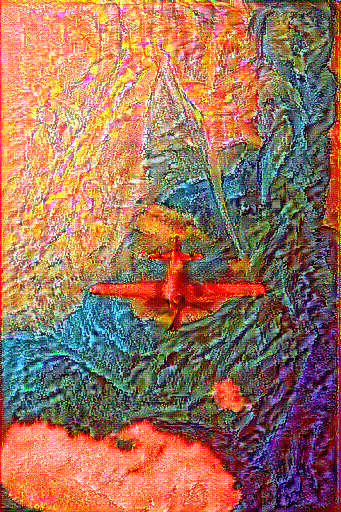

Train step: 60
Total time: 3151.6


array([[[ 69,  57, 236],
        [ 86,  92, 254],
        [ 88, 115, 252],
        ...,
        [225, 132, 116],
        [217, 186, 197],
        [119, 164, 123]],

       [[ 78,  85, 255],
        [ 84, 107, 251],
        [ 84, 152, 254],
        ...,
        [ 45,   0,  99],
        [ 17,   8, 201],
        [  0,   0, 100]],

       [[ 26,  24, 254],
        [ 71,  92, 255],
        [ 29, 105, 249],
        ...,
        [  0,   0, 154],
        [  0,   0, 197],
        [  0,  46, 152]],

       ...,

       [[  0,   0, 175],
        [  0,   0,  52],
        [  0,   5, 115],
        ...,
        [  0,   1, 118],
        [  0,   0, 183],
        [  0,   0, 139]],

       [[  0,   0, 170],
        [ 24,   0,  90],
        [ 23,  40,  84],
        ...,
        [  0,   7, 119],
        [  0,   0, 124],
        [  0,   0, 176]],

       [[  0,   0, 170],
        [  0,   0, 100],
        [ 12,  20,  64],
        ...,
        [  0,   0, 132],
        [  0,   0, 177],
        [  3,   0, 197]]

[0.668328048112394, 0.3705814847116816, 1.195484498545862]
MSE: 9506.445809876543
SSIM: 0.07601855982762618


In [9]:
start = time.time()

epochs = 2#5
steps_per_epoch = 30#60

open('./StylizedImages/Mobile/Metrics', 'w').close()

for i in allImagesContent: #allImagesContent
    counter = 0
    
    # Change this to + i if you want all of the pictures
    
    ##Change
    test_content = load_img('./ImagesForTraining/' + i)
    display.display(tensor_to_image(test_content))
    
    
    for j in allImagesStyle: #allImagesStyle
        
        test_style = load_img('./Art/images/images/Vasiliy_Kandinskiy/' + j)
        
        x = tf.keras.applications.mobilenet.preprocess_input(test_content*255)
        x = tf.image.resize(x, (224, 224))
        mobile_net = tf.keras.applications.MobileNet(include_top=True, weights='imagenet')
        
        mobile_net = tf.keras.applications.MobileNet(include_top=False, weights='imagenet')
        
        
        ## Information from where we are extracting the Information out
        content_layers = ['conv_pw_13'] 

        style_layers = ['conv_pw_1',
                       'conv_pw_4',
                        'conv_pw_6',
                        'conv_pw_8',
                        'conv_pw_10',
                        'conv_pw_12',
                       'conv_pw_13']

        num_content_layers = len(content_layers)
        num_style_layers = len(style_layers)
        
        ## Why do we need this?
        def mobile_net_layers(layer_names):
          """ Creates a MobileNet model that returns a list of intermediate output values."""
          # Load our model. Load pretrained MobileNet, trained on ImageNet data
          mobile_net = tf.keras.applications.MobileNet(include_top=False, weights='imagenet')
          mobile_net.trainable = False

          outputs = [mobile_net.get_layer(name).output for name in layer_names]

          model = tf.keras.Model([mobile_net.input], outputs)
          return model
    
        style_extractor = mobile_net_layers(style_layers)
        style_outputs = style_extractor(test_style*255)
        
        ## Compute the gram Matrix
        def gram_matrix(input_tensor):
          result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
          input_shape = tf.shape(input_tensor)
          num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
          return result/(num_locations)
        
        ## Compute the style and Content outputs for a give image
        class StyleContentModel(tf.keras.models.Model):
          def __init__(self, style_layers, content_layers):
            super(StyleContentModel, self).__init__()
            self.mobilenet = mobile_net_layers(style_layers + content_layers)
            self.style_layers = style_layers
            self.content_layers = content_layers
            self.num_style_layers = len(style_layers)
            self.mobilenet.trainable = False

          def call(self, inputs):
            "Expects float input in [0,1]"
            inputs = inputs*255.0
            preprocessed_input = tf.keras.applications.mobilenet.preprocess_input(inputs)
            outputs = self.mobilenet(preprocessed_input)
            style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                              outputs[self.num_style_layers:])

            style_outputs = [gram_matrix(style_output)
                             for style_output in style_outputs]

            content_dict = {content_name: value
                            for content_name, value
                            in zip(self.content_layers, content_outputs)}

            style_dict = {style_name: value
                          for style_name, value
                          in zip(self.style_layers, style_outputs)}

            return {'content': content_dict, 'style': style_dict}
        
        ## Uses the Style Model
        extractor = StyleContentModel(style_layers, content_layers)


        style_targets = extractor(test_style)['style']
        content_targets = extractor(test_content)['content']

        results = extractor(tf.constant(test_content))
        
        image = tf.Variable(test_content)
        
        def clip_0_1(image):
            return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
        
        
        opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
        
        style_weight=1e8
        content_weight=1e-2
        
        ## Compute the losses for the style and the content
        def style_content_loss(outputs):
            style_outputs = outputs['style']
            content_outputs = outputs['content']
            style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                                   for name in style_outputs.keys()])
            style_loss *= style_weight / num_style_layers

            print("Style loss")
            print(style_loss)

            content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                                     for name in content_outputs.keys()])

            print("Content loss")
            content_loss *= content_weight / num_content_layers
            print(content_loss)
            loss = style_loss + content_loss
            return loss
        
        total_variation_weight=10
        
        
        ## Make Gradient Descent
        @tf.function()
        def train_step(image):
          with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_content_loss(outputs)
            print("Total")
            print(loss)
            loss += total_variation_weight*tf.image.total_variation(image)

          grad = tape.gradient(loss, image)
          opt.apply_gradients([(grad, image)])
          image.assign(clip_0_1(image))
        
        display.display(tensor_to_image(test_style))

        step = 0
        for n in range(epochs):
          for m in range(steps_per_epoch):
            step += 1
            train_step(image)
            print()
            print(".", end='', flush=True)
          display.clear_output(wait=True)
          display.display(tensor_to_image(image))
          print("Train step: {}".format(step))
          
        end = time.time()
        print("Total time: {:.1f}".format(end-start))
        file_name = i + j + '.png'
        tensor_to_image(image).save('./StylizedImages/Mobile/' + file_name)
        
        
        
        ##Compute Metrics
        
        image_style = cv2.imread('./Art/images/images/Vasiliy_Kandinskiy/' + j)
        image_result = cv2.imread('./StylizedImages/Mobile/' + file_name)
        image_content = cv2.imread('./ImagesForTraining/' + i)

        display.display(image_result)
        height_test, width_test, depth_test = image_style.shape

        
        image_content = cv2.resize(image_content, (width_test, height_test))

        image_result = cv2.resize(image_result, (width_test, height_test))
        
        
        
        
        channels1 = cv2.split(image_style)
        channels2 = cv2.split(image_result)
        
        hist1 = [cv2.calcHist([channel], [0], None, [256], [0, 256]) for channel in channels1]
        hist2 = [cv2.calcHist([channel], [0], None, [256], [0, 256]) for channel in channels2]

        ## Normalize for good comparison of Chi Squared
        hist1 = [hist / hist.sum() for hist in hist1]
        hist2 = [hist / hist.sum() for hist in hist2]
        
        chi_square_distances = [cv2.compareHist(h1, h2, cv2.HISTCMP_CHISQR) for h1, h2 in zip(hist1, hist2)]

        print(chi_square_distances)
        
        
        
        ssim_value = main(image_result, image_style)
        
        with open('./StylizedImages/Mobile/Metrics', 'a') as f:
            f.write('Image and Style:' + i + j + "\n")
        
        with open('./StylizedImages/Mobile/Metrics', 'a') as f:
            f.write('SSIM Value: ' + str(ssim_value) + "\n")
            
            
        with open('./StylizedImages/Mobile/Metrics', 'a') as fp:
            for item in chi_square_distances:
            # write each item on a new line
                fp.write("%s\n" % item)


        
## Questions: 
# Whats the starting image?